In [1]:
class alk_atom:
    def __init__(self,myList:list):
        # test the type of the list and trck error
        #try:
            self.MakeAtomFromList(myList)
            self.N = len(self.M)

        # except:
        #     print("error in construction format inpout. exemple of acceptable inpout: [ [0,[3,4]] , [1,[3,4]] ]")
        # pass

    def AddLeveltoList(self,Level:list):
          # Level exemple of list structure: [0,[1,2]], for l=0 ; F=1 and F=2
        self.LevelList.append(Level)
        self.MakeAtomFromList(myList)
        
    def MakeAtomFromList(self,myList):
            N = len(myList)
            self.LevelList = myList
            self.F = []
            self.principal = []
            self.M = []

            for l in range(0,N):
                Line = myList[l] # get l orbital number. l=0 for 6S1/2 , l=1 for 6P1/2 and 6P3/2
                F = Line[1]      # get list of hyperfine F values
                for f in range(0,len(F)):
                     for m in range(0,F[f]*2+1):
                        self.principal.append(Line[0])
                        self.F.append(F[f])
                        self.M.append( - F[f] + m )

    def BuildMvector(self):
        self.M = []
        for i in range(0,len(self.F)):
             for m in range(0,self.F[i]*2+1):
                self.M.append( - self.F[i] + m )

    def printAtom(self):
        print(self.LevelList)
        print(self.principal)
        print(self.F)
        print(self.M)

In [3]:
# initialize by list of line est hyperfine levels to account for
# exmple [l=0, F=[3,4]] is the 6S1/2 level, for F=3 and F=4.
# All mF level will be automatically filled by -F<= mF <= F.
# To reduce the number of mF level, the function DefineMf should use to overwrite.
myList = [[1,[2,3]]]

my_cesium = alk_atom(myList)
my_cesium.printAtom()



[[1, [2, 3]]]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3]
[-2, -1, 0, 1, 2, -3, -2, -1, 0, 1, 2, 3]


In [4]:
# create a density matrix of size 2 usinf Fock base preparation

RHO0 = fock_dm(2)
print(RHO0)

# creation of ket in ground state using basis(n=dim,0:for ground state)
phi0 = basis(3,0)
print(phi0)

# identity operator
print(qeye(3))

# a operator in the Fock basis of dimention N
print(destroy(2))

# Number operator in the Fock basis of dimension N
print(num(2))

# build collapse operator which is a "list"
c_ops = []
c_ops.append(0)
c_ops.append(0.5)
c_ops.append(1)
print(type(c_ops))
print(c_ops)


#print(phi0*phi0.dag())
#help(tensor)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]
<class 'list'>
[0, 0.5, 1]


In [5]:
# building a Hamiltoninan using 
H = 2*np.pi * 0.1 * sigmax()

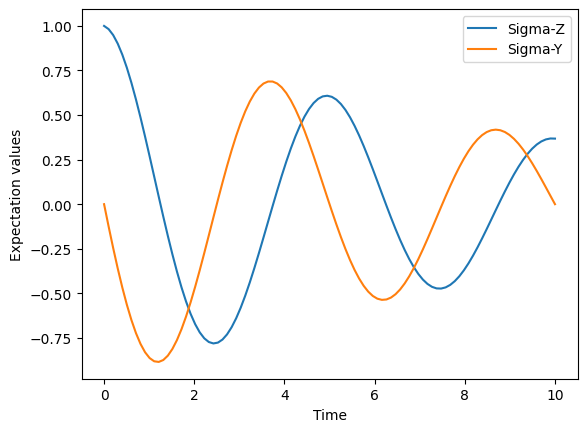

In [6]:

# definition os the ket of dimension 2 : basis(2, 0)
psi0 = basis(2, 0)

times = np.linspace(0.0, 10.0, 100)

result = mesolve(H, psi0, times, [np.sqrt(0.05) * sigmax()], [sigmaz(), sigmay()])

fig, ax = plt.subplots()

ax.plot(times, result.expect[0]) 

ax.plot(times, result.expect[1]) 

ax.set_xlabel('Time') 

ax.set_ylabel('Expectation values') 

ax.legend(("Sigma-Z", "Sigma-Y"))  

plt.show() 

In [29]:
# definition of a time vaying coefficient for Time dependant Hamiltoninan solver
def H1_coeff(t,arg):
    return 9 * np.exp( -(t/5.) ** 2 )

In [59]:
# exemple of Time varying Hamiltoninan
ground  = basis(3, 0)
ustate  = basis(3, 1)
excited = basis(3, 2)

N = 2 # Set where to truncate Fock state for cavity
# build the tensorial operator space
sigma_ge = tensor(qeye(N), ground * excited.dag())  # I x |g><e|
sigma_ue = tensor(qeye(N), ustate * excited.dag())  # I x |u><e|
a        = tensor(destroy(N), qeye(3))              # a x I
ada      = tensor(num(N), qeye(3))                  # ada x I

c_ops = []  # Build collapse operators as a list of successive loss terms
kappa = 1.5 # Cavity decay rate
gamma = 6  # Atomic decay rate
c_ops.append(np.sqrt(kappa) * a) # destruction operator : losses in cavity which do no affect atoms
c_ops.append(np.sqrt(4*gamma/9) * sigma_ge) # atomic decays from e to g
c_ops.append(np.sqrt(5*gamma/9) * sigma_ue) # atomic decays from e to u

t = np.linspace(-15, 15, 100) # Define time vector
psi0 = tensor(basis(N, 0), ustate) # Define initial state

g = 5  # coupling strength
H0 = -g * (sigma_ge.dag() * a + a.dag() * sigma_ge)  # time-independent term
H1 = (sigma_ue.dag() + sigma_ue)                     # time-dependent term

H = [H0,[H1, H1_coeff]] # define the time-varying Hamiltonian


# define the projection dictorary
state_GG = tensor(basis(N, 1), ground) # Define states onto which to project
sigma_GG = state_GG * state_GG.dag()
state_UU = tensor(basis(N, 0), ustate)
sigma_UU = state_UU * state_UU.dag()

# [ada, sigma_UU, sigma_GG] : Dictionary of scope parameters for time-dependent Hamiltonians
#output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG])

opts = Options()
opts.store_states = True
opts.store_final_state = True
print(opts)

output = mesolve(H, psi0, t, c_ops, options=opts)

# attribute of output (check : https://qutip.org/docs/latest/apidoc/classes.html#qutip.solver.Options )
# times : Times at which simulation data was collected
# expect: list/array Expectation values (if requested) for simulation.
# states : array , State of the simulation (density matrix or ket) evaluated at times.

print(output)

# fig, ax = plt.subplots()

# ax.plot(t, output.expect[0]) 

# ax.plot(t, output.expect[1]) 

# ax.set_xlabel('Time') 

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          8
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      True
store_final_state: True

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 3
